This notebook implementes the differential gene expression tests for the clonotype clusters

In [104]:
import numpy as np
import pandas as pd

import scanpy as scp

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from functools import reduce

import seaborn as sns
from matplotlib import pyplot as plt

import gseapy as gp

import os
import pickle as pkl

import warnings

%load_ext jupyter_black

import warnings

warnings.simplefilter("ignore", category=UserWarning)

# Load preprocessed adata
adata = scp.read("adata_CD8_velocity_all.h5ad")
add_clono = False
print(adata.shape)

# preprocess
# remove patient LHCC48
adata = adata[adata.obs.index[adata.obs.Patient != "LHCC48"]]

# pd.read_csv("clonotype_clusters.csv")

tcr_adata = scp.read("TCR_data.h5ad")

# add tcr clonotypes to main adata
adata.obs["Clonotype"] = pd.Categorical(
    [
        tcr_adata.obs.loc[idx]["clone_id"] if idx in tcr_adata.obs.index else pd.NA
        for idx, cell in adata.obs.iterrows()
    ]
)
# "clonotype_clusters_spectral_cosine.csv")
adata.obs["Clonotype cluster"] = (
    pd.read_csv("clonotype_clusters_kmeans_5_clusters_good.csv")
    .set_index("new_index")["Clonotype cluster"]
    .astype("category")
)

adata.obs["Cluster and type"] = list(
    cluster + "_" + ctype
    for cluster, ctype in zip(
        adata.obs["Clonotype cluster"], adata.obs["Cluster label"]
    )
)

adata.obs["Cluster and patient"] = list(
    cluster + "_" + ctype
    for cluster, ctype in zip(adata.obs["Clonotype cluster"], adata.obs["Patient"])
)

adata.layers["counts"] = adata.raw.X.copy()
adata.layers["counts"] = scp.pp.normalize_total(adata.raw.copy(), inplace=False)["X"]
adata.layers["counts"] = np.log1p(adata.layers["counts"])

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
(11766, 7109)


In [105]:
cluster_index = [x.split("_")[0] for x in list(adata.obs["Cluster label"].unique())]
cluster_index = [int(x[1:]) for x in cluster_index]
cluster_index = np.argsort(cluster_index)
color_dict = {}
for color, cluster in zip(
    adata.uns["Cluster label_colors"],
    adata.obs["Cluster label"].unique()[cluster_index],
):
    color_dict[cluster] = color

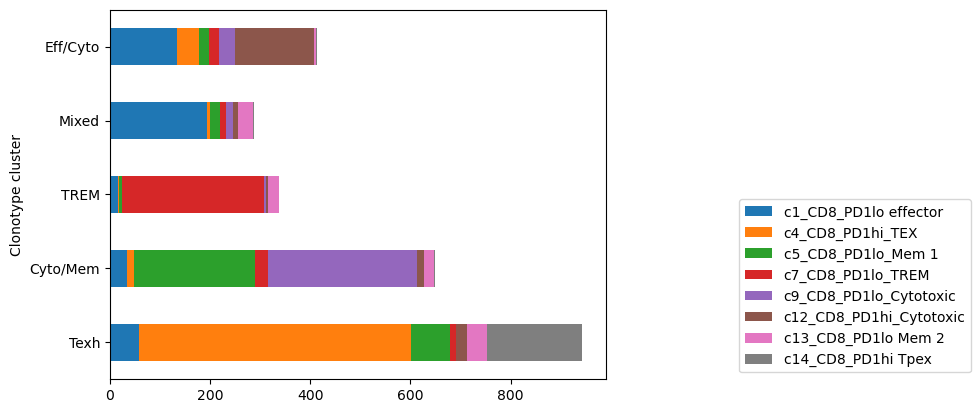

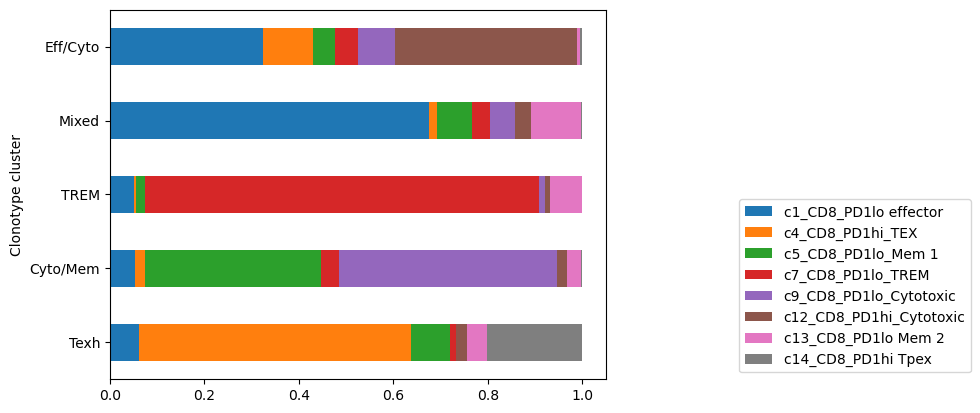

In [106]:
count_df_ = (
    adata.obs[adata.obs["Clonotype cluster"] != "-1"]
    .value_counts(["Clonotype cluster", "Cluster label"])
    .reset_index()
    .pivot(index="Clonotype cluster", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True, color=color_dict)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True, color=color_dict)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [107]:
# Check cell counts
count_df_

Cluster label,c1_CD8_PD1lo effector,c4_CD8_PD1hi_TEX,c5_CD8_PD1lo_Mem 1,c7_CD8_PD1lo_TREM,c9_CD8_PD1lo_Cytotoxic,c12_CD8_PD1hi_Cytotoxic,c13_CD8_PD1lo Mem 2,c14_CD8_PD1hi Tpex
Clonotype cluster,,,,,,,,
Texh,58.0,543.0,78.0,11.0,0.0,22.0,40.0,191.0
Cyto/Mem,35.0,13.0,242.0,25.0,299.0,14.0,19.0,2.0
TREM,17.0,2.0,6.0,282.0,4.0,4.0,23.0,0.0
Mixed,194.0,5.0,21.0,11.0,15.0,10.0,30.0,1.0
Eff/Cyto,134.0,44.0,19.0,20.0,32.0,159.0,3.0,2.0


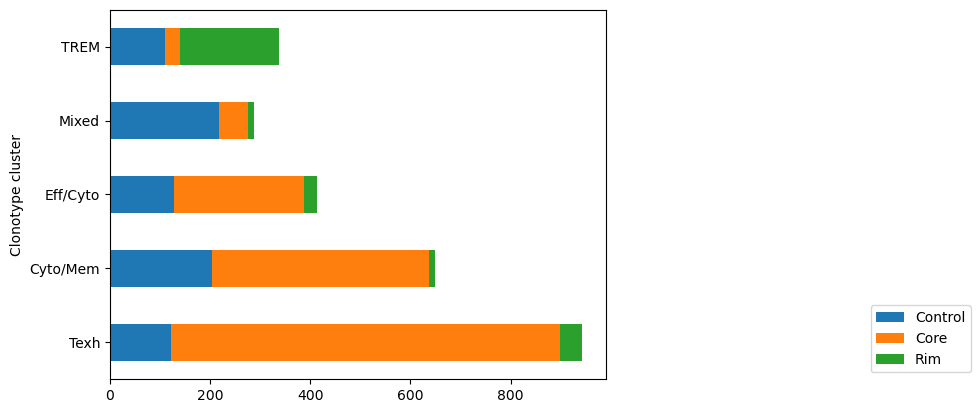

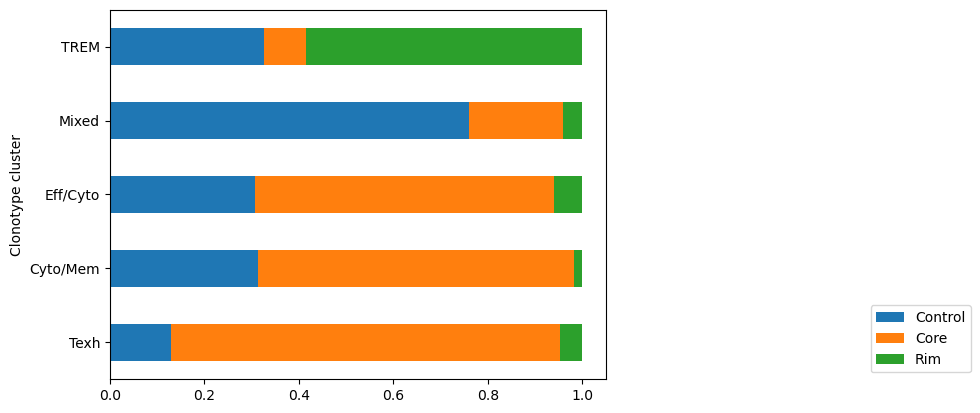

In [16]:
count_df_ = (
    adata.obs[adata.obs["Clonotype cluster"] != "-1"]
    .value_counts(["Clonotype cluster", "Tissue"])
    .reset_index()
    .pivot(index="Clonotype cluster", columns="Tissue", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm = count_df_.div(count_df_.sum(axis=1), axis=0)
count_df__norm.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

In [23]:
# Function to perform DE analysi with scanpy statistical tests on subsets of data and plot the results
def scanpy_rank_genes(
    adata,
    method="t-test",
    groupby="Clonotype cluster",
    groups="all",
    reference="rest",
    pval_cutoff=0.05,
    min_in_fraction=0.25,
    max_out_fraction=0.5,
):
    scp.tl.rank_genes_groups(
        adata,
        groupby=groupby,
        groups=groups,
        method=method,
        key_added=method,
        reference=reference,
        layer="counts",
        use_raw=False,
    )

    scp.tl.filter_rank_genes_groups(
        adata,
        key_added=f"{method}-filtered",
        key=method,
        min_in_group_fraction=min_in_fraction,
        max_out_group_fraction=max_out_fraction,
    )

    genes = adata.uns[method]["names"].tolist()
    genes = np.array(list(sum(genes, ())))
    genes = [g for g in genes if g != "nan"]
    genes = list(set(genes))

    filtered_genes = adata.uns[f"{method}-filtered"]["names"].tolist()
    filtered_genes = np.array(list(sum(filtered_genes, ())))
    filtered_genes = [g for g in filtered_genes if g != "nan"]
    filtered_genes = list(set(filtered_genes))
    n_genes = len(filtered_genes)

    print(
        f"Before fraction filtering: {len(genes)} After fraction filtering: {n_genes}"
    )

    de_df = scp.get.rank_genes_groups_df(
        adata, group=None, key=f"{method}-filtered"
    ).dropna()

    de_df_unfiltered = scp.get.rank_genes_groups_df(
        adata, group=None, key=f"{method}"
    ).dropna()

    if method != "logreg":
        print(de_df["pvals_adj"].min())
        de_df = de_df[de_df["pvals_adj"] < pval_cutoff]
        filtered_genes = list(set(de_df["names"].values))
        n_genes = len(filtered_genes)

        var_names = {}
        for g in de_df["group"].unique():
            var_names[g] = list(de_df[de_df["group"] == g]["names"].values)
    else:
        var_names = filtered_genes

    print(f"After pval filtering: {n_genes}")

    if groups == "all":
        groups = None
    scp.pl.rank_genes_groups_dotplot(
        adata,
        groupby=groupby,
        groups=groups,
        # n_genes=n_genes,
        var_names=var_names,
        standard_scale="var",
        key=f"{method}-filtered",
        dendrogram=False,
    )

    scp.pl.rank_genes_groups_stacked_violin(
        adata,
        groupby=groupby,
        groups=groups,
        # n_genes=n_genes,
        var_names=var_names,
        standard_scale="var",
        key=f"{method}-filtered",
        dendrogram=False,
    )

    return de_df.set_index("names"), de_df_unfiltered.set_index("names")

In [84]:
def compare_groups(
    adata,
    groups,
    group_column="Cluster and type",
    pval_cutoff=0.5,
    min_in_fraction=0.0,
    max_out_fraction=1000,
    method="wilcoxon",
):

    indices = []
    for g in groups:
        indices.append(adata.obs[group_column] == g)

    indices = reduce(lambda x, y: x | y, indices)

    de_df, de_df_unfiltered = scanpy_rank_genes(
        adata[indices],
        method=method,
        groupby=group_column,
        groups=groups,
        pval_cutoff=pval_cutoff,
        min_in_fraction=min_in_fraction,
        max_out_fraction=max_out_fraction,
    )

    count_df_ = (
        adata[indices]
        .obs.value_counts([group_column, "Tissue"])
        .reset_index()
        .pivot(index=group_column, columns="Tissue", values="count")
    ).fillna(0)
    count_df_.plot.barh(stacked=True)
    plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
    plt.show()
    return de_df, de_df_unfiltered

In [86]:
#define gene groups for GSEA
annotated_genes = {
    "General T cell marker": ["CD3D", "CD3E", "CD3G", "CD8A", "CD8B", "CD4"],
    "Naïve, effector/memory": [
        "IL7R",
        "CCR7",
        "KLF2",
        "LEF1",
        "TCF7",
        "CD44",
        "SELL",
        "FOSB",
    ],
    "Tissue residency": [
        "VIM",
        "ITGAE",
        "ZNF683",
        "CD69",
        "CCR6",
        "CXCR6",
    ],
    "Effector molecules": [
        "HLA-DRA",
        "CCL4",
        "CCL4L2",
        "IL2",
        "IL17A",
        "IL21",
        "IL32",
        "IFNG",
        "TNF",
        "GZMA",
        "GZMB",
        "GZMC",
        "GZMH",
        "GZMK",
        "GZMM",
    ],
    "Chronic activation": [
        "PDCD1",
        "LAG3",
        "CTLA4",
        "HAVCR2",
        "ENTPD1",
        "TIGIT",
        "CD38",
        "DUSP4",
        "TOX2",
        "LAYN",
        "CXCL13",
    ],
    "Cytotoxicity": ["GNLY", "PRF1", "NKG7", "FCGR3A", "TYROBP", "KLRG1", "KLRB1"],
    # "MAIT": [
    #    "TRAV1-2",
    #    "KLRB1",
    #    "SLC4A10",
    #    "NCR3",
    # ],
    "Progenitor": [
        "IL6ST",
        "XCL1",
        "CD160",
        "CD200",
        "BTLA",
        "GNG4",
        "XCL1",
        "XCL2",
    ],
    # "Treg": ["FOXP3", "IL2RA", "IKZF2"],
    "Proliferation": ["MKI67", "PCNA", "STMN1", "STMN1", "HMGN2"],
}

Before fraction filtering: 7109 After fraction filtering: 1729
1.3254478811550007e-10
After pval filtering: 11


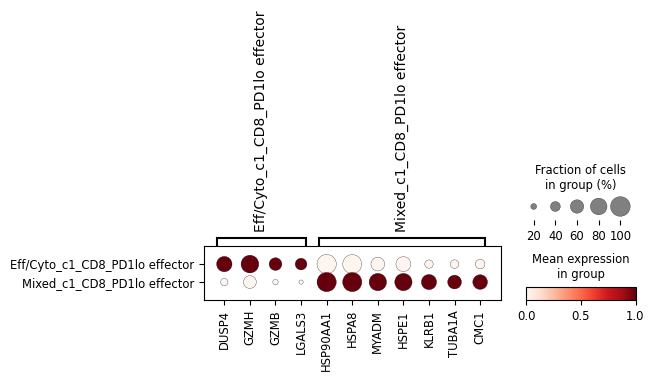

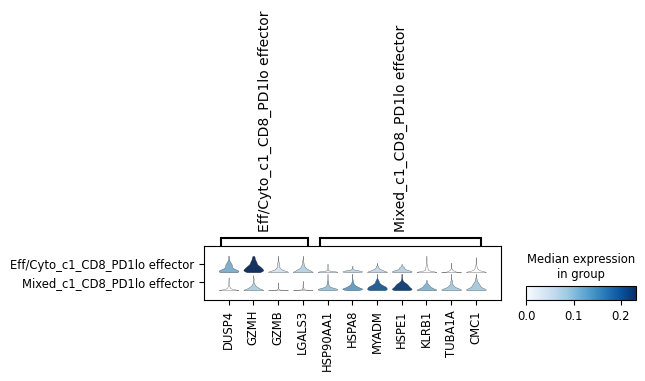

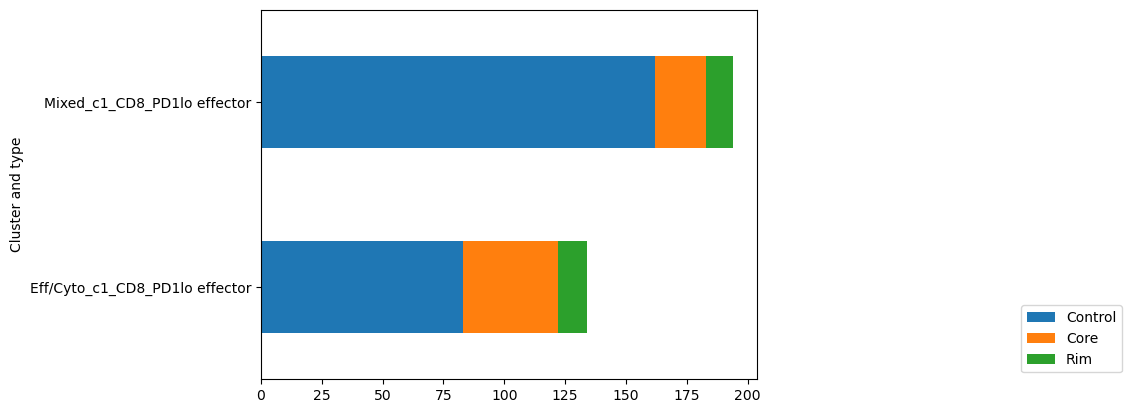

In [97]:
groups = [
    "Eff/Cyto_c1_CD8_PD1lo effector",
    "Mixed_c1_CD8_PD1lo effector",
]

de_df, de_df_unfiltered = compare_groups(adata=adata, groups=groups, pval_cutoff=1e-5)

Eff/Cyto_c1_CD8_PD1lo effector


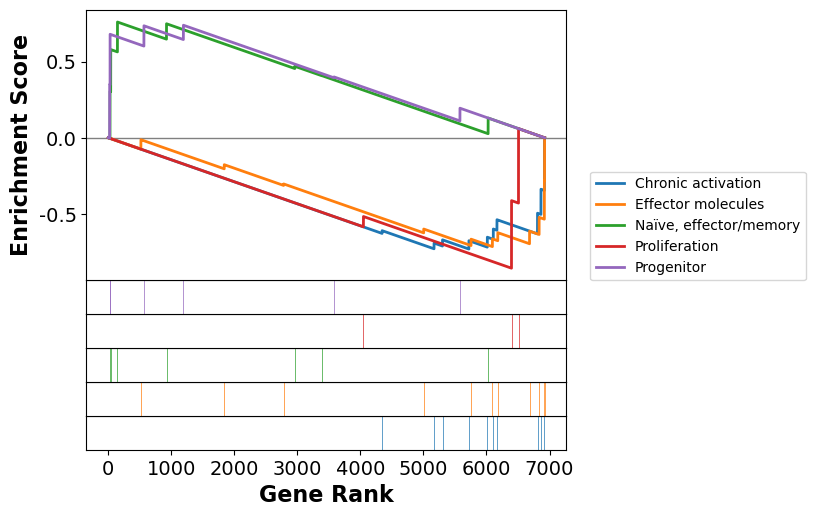

In [98]:
indices = []
for g in groups:
    indices.append(adata.obs["Cluster and type"] == g)

indices = reduce(lambda x, y: x | y, indices)

data = adata[indices].X.toarray()

data_df = pd.DataFrame(index=adata.var_names, data=data.T)

gs_res = gp.gsea(
    data=data_df,
    gene_sets=annotated_genes,
    cls=adata[indices].obs["Cluster and type"],
    permutation_type="phenotype",
    permutation_num=1000,  # reduce number to speed up test
    outdir=None,  # do not write output to disk
    method="signal_to_noise",
    min_size=3,
    threads=4,
    seed=7,
)

print(gs_res.pheno_neg)

terms = gs_res.res2d.Term
axs = gs_res.plot(
    terms[:5],
    show_ranking=False,
    legend_kws={"loc": (1.05, 0)},
)

Before fraction filtering: 7109 After fraction filtering: 2488
1.1931086746936826e-24
After pval filtering: 31


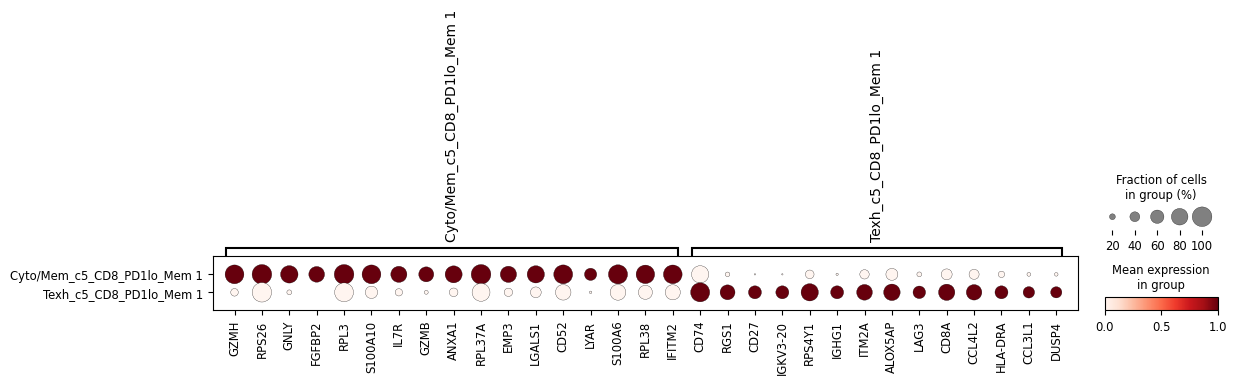

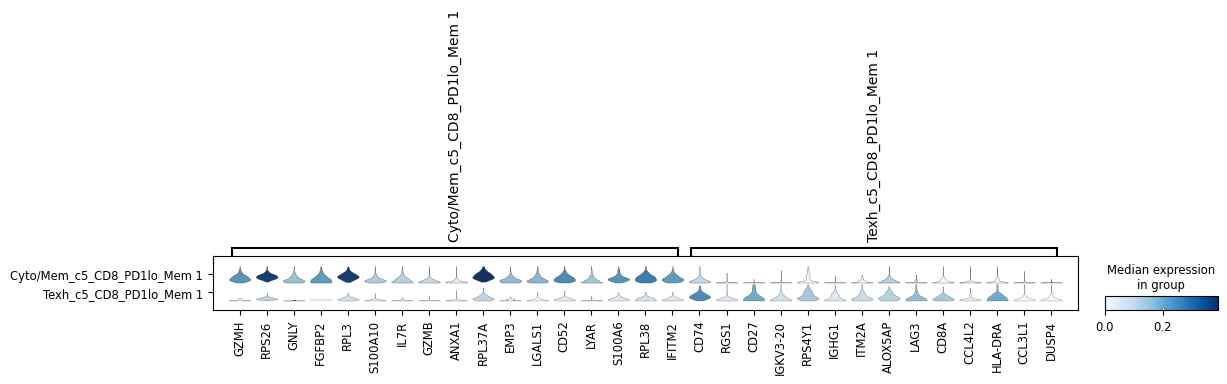

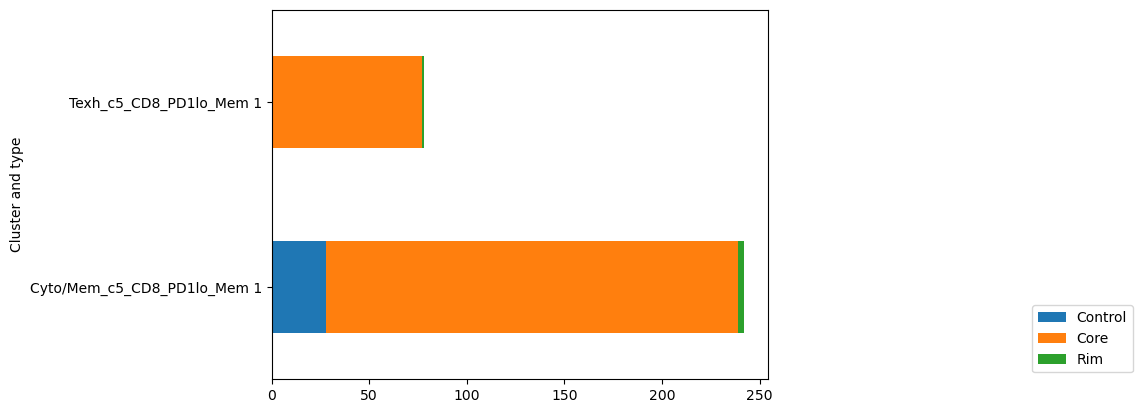

In [91]:
groups = [
    # "Eff/Cyto_c13_CD8_PD1lo Mem 2",
    "Cyto/Mem_c5_CD8_PD1lo_Mem 1",
    # "TREM_c13_CD8_PD1lo Mem 2",
    # "Mixed_c13_CD8_PD1lo Mem 2",
    "Texh_c5_CD8_PD1lo_Mem 1",
]

de_df, de_df_unfiltered = compare_groups(adata=adata, groups=groups, pval_cutoff=1e-5)

Texh_c5_CD8_PD1lo_Mem 1


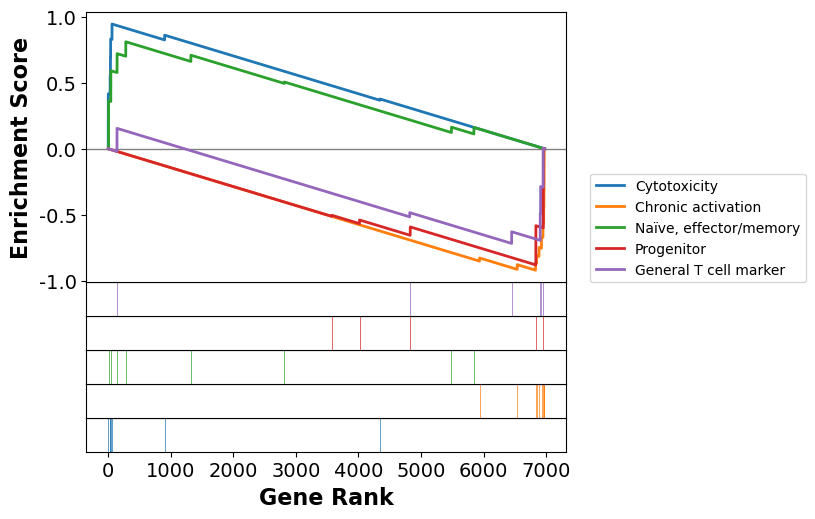

In [92]:
indices = []
for g in groups:
    indices.append(adata.obs["Cluster and type"] == g)

indices = reduce(lambda x, y: x | y, indices)

data = adata[indices].X.toarray()

data_df = pd.DataFrame(index=adata.var_names, data=data.T)

gs_res = gp.gsea(
    data=data_df,
    gene_sets=annotated_genes,
    cls=adata[indices].obs["Cluster and type"],
    permutation_type="phenotype",
    permutation_num=1000,  # reduce number to speed up test
    outdir=None,  # do not write output to disk
    method="signal_to_noise",
    min_size=3,
    threads=4,
    seed=7,
)

print(gs_res.pheno_neg)

terms = gs_res.res2d.Term
axs = gs_res.plot(
    terms[:5],
    show_ranking=False,
    legend_kws={"loc": (1.05, 0)},
)